# Apply perturbations to SI3 restart file

_Last update:_ 2024-12-12

_Author_: Stephanie Leroux, Datlas.

__Goal:__ My notes to explain how to use the lu-simulator to apply location perturbation in the initial state of the Arctic-BLISS project ensemble simulations. Read first my notes about generating the perturbations. 

---

## 0. Load Python packages

In [1]:
## standart libraries
import os,sys
import sys
import glob

import numpy as np
from scipy import stats

# xarray
import xarray as xr

# plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

from IPython.display import HTML

# for jupyter notebook display
%matplotlib inline

def Fsaveplt(fig,diro,namo,dpifig=300):
    """Save plot to file.
    
    Parameters:
    - fig: Figure properties to save.
    - diro (str): Output directory.
    - namo (str): Name of the output plot.
    - dpifig (int): Resolution (dpi) of saved plot.
    
    Returns:
    None
   """
    
    fig.savefig(diro+namo+".png", facecolor=fig.get_facecolor(),
                edgecolor='none',dpi=dpifig,bbox_inches='tight', pad_inches=0.01)
    print(diro+namo+".png")
    plt.close(fig) 

## 1. Set up environment

* Set up and go to working directory

In [2]:
%cd /lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/
LUdir="/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/"

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples


* Load python:
  Note: on Jean Zay, need to load same python install as when the ensdam software was compiled:
```bash
module unload python
module load climate_science
```

---

## 2. Apply location perturbations to the sea ice fields  in the NEMO-SI3restart file 

The dx,dy perturbations previously generated (see my other notebook) will now be applied to the sea ice fields of the NEMO-SI3 restart file, with a Standard Deviation set to a choosen value in kilometer, i.e. the dx,dy perturbations applied to the firleds are scaled to have a STD of xxx km. 

The range of possible STDs to apply depends on the choice on the damping length scale and correlation scale of the perturbations.

Example of what is possible to produce:

* `001l500_std100_interplinear_perturbed_lgrid15sm3_D0.nc`
* `001l500_std50_interplinear_perturbed_lgrid10sm3_D0.nc`
* `001l500_std20_interplinear_perturbed_lgrid5sm3_D0.nc`
* `001l500_std10_interplinear_perturbed_lgrid5sm3_D0.nc`
* `001l500_std1_interplinear_perturbed_lgrid5sm3_D0.nc`

```bash
#!/bin/bash

# Input parameters
NTOT=20  # Number of samples generated in the perturbation file
N=2      # Number of members to generate
l_values=(500)  # Split the second argument into an array of length scales in km
std_values=( 10 )
lgrid=5
sm=3      # smoothing term in damping factor
interp="linear"

# Input files
grid_file="grid.nc"
mask_file="mask.nc"
vargrid_file="varlistinfo.asc"
unmasked_reference="unmasked_reference.nc"
damping_factor="damping_factor_lgrid${lgrid}_sm${sm}_R0.nc"

# Loop over the values of l and std
for l in "${l_values[@]}"; do

        perturbation_file="perturbation_sample_${l}km_N${NTOT}.nc"

        # Now loop over std values for the final step
        for std in "${std_values[@]}"; do

                # Output filename
                output_file="l${l}_std${std}_interp${interp}_perturbed_lgrid${lgrid}sm${sm}_R1.nc"

                python ../src/apply_perturbations.py -m ${N} -std $std -grid $grid_file  -mask ${mask_file} -i $perturbation_file -ref $unmasked_reference -factor ${damping_factor} -v $vargrid_file -interp ${interp} -o $output_file
        done
done

```

---

## 3 Load files before plotting

In [33]:
ls=500
lgrid = 10
label="D0"
std=10

# Load datasets:
# mask file
mask = xr.open_dataset("mask.nc", decode_times=True)

# daming coeff
damping = xr.open_dataset("damping_factor_lgrid"+str(lgrid)+"_sm3_"+label+".nc", decode_times=True)

# grid
grid = xr.open_dataset("grid.nc", decode_times=True)

# perturbation file
pert =  xr.open_dataset("perturbation_sample_"+str(ls)+"km_N20.nc",decode_times=True)

# reference (unperturbed) restart file
ref= xr.open_dataset("unmasked_reference.nc", decode_times=True)

# prepare to read  perturbed restart files (all members) for a given set of parameters
file_pattern = "*l"+str(ls)+"_std"+str(std)+"_interplinear_perturbed_lgrid"+str(lgrid)+"sm3_"+label+".nc"

# Use glob to find all matching files
file_list = sorted(glob.glob(file_pattern))  # Sort to ensure consistent ordering

# Initialize an empty list to hold datasets
datasets = []

# Load each file, adding a new dimension for identification
for i, file in enumerate(file_list):
    ds = xr.open_dataset(file, decode_times=True)
    # Assign a new coordinate `member` to distinguish files
    ds = ds.expand_dims(member=[i + 1])  # Start realizations from 1
    datasets.append(ds)

# Combine all datasets along the new `realization` dimension
pertfields = xr.concat(datasets, dim="member")

## 4. Plot dx,dy perturbation for 2 members:
(On top of which the damping coeff is also shown)

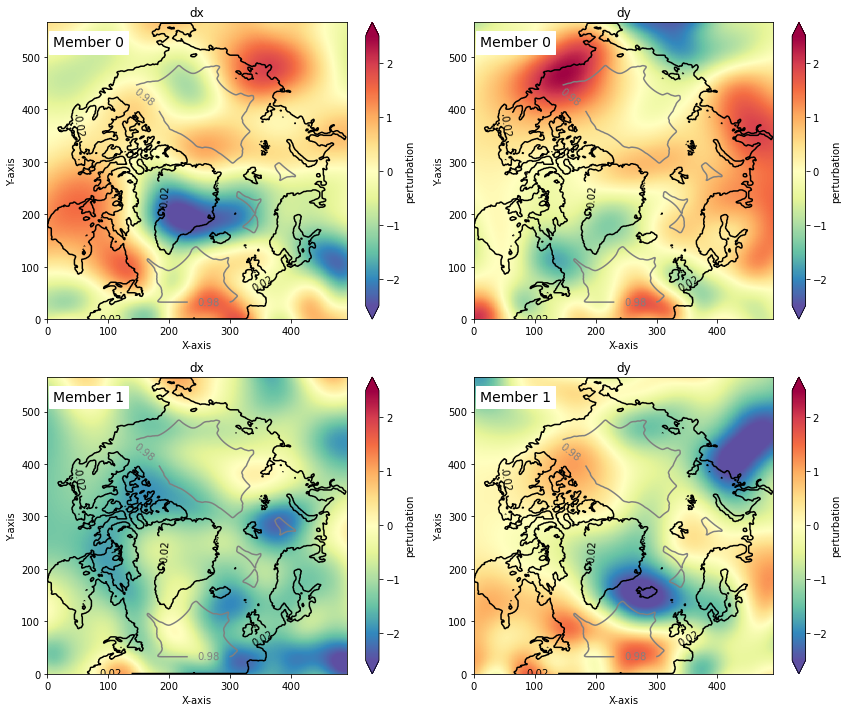

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/pert_4panels_ls500km_lgrid10_D0.png


In [34]:

# Define data to plot
data2plt_dx = pert.dx
data2plt_dy = pert.dy
cmap = cm.Spectral_r  # Colormap

# Number of members to plot
members = [0, 1]  # Member indices

# Compute the grid scaling factor
grid_factor = np.sqrt(0.5 * (grid["e1t"][0, :, :]**2 + grid["e2t"][0, :, :]**2))
grid_factor = grid_factor / 1000.0  # Convert to km

# Scale the damping coefficient
scaled_damping = damping["a_i"] * grid_factor

# Define contour levels and colors
contour_levels = [0.02, 0.98]
contour_colors = ['black', 'gray']

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=[12, 10], facecolor='w')

# Set common vmin and vmax for the color scale
vmin, vmax = -2.5, 2.5

# Loop over members and fields
for i, member in enumerate(members):
    # Plot pert.dx
    ax = axes[i, 0]
    p = ax.pcolormesh(data2plt_dx.isel(member=member).values, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(f"dx")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    fig.colorbar(p, ax=ax, label='perturbation', extend='both')
    # Add member annotation
    ax.text(10, 520, f"Member {member}", fontsize=14, color="k", backgroundcolor='white')

    # Add mask
    #mask["a_i"][0, 0, :, :].plot(ax=ax, add_colorbar=False, alpha=0.3)

    # Add contours
    contour = ax.contour(
        scaled_damping[0, 0, :, :],
        levels=contour_levels,
        colors=contour_colors,
        linewidths=1.5
    )
    ax.clabel(contour, inline=True, fontsize=10, fmt='%1.2f')

    # Plot pert.dy
    ax = axes[i, 1]
    p = ax.pcolormesh(data2plt_dy.isel(member=member).values, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(f"dy")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    fig.colorbar(p, ax=ax, label='perturbation', extend='both')
    # Add member annotation
    ax.text(10, 520, f"Member {member}", fontsize=14, color="k", backgroundcolor='white')

    # Add mask
    #mask["a_i"][0, 0, :, :].plot(ax=ax, add_colorbar=False, alpha=0.3)

    # Add contours
    contour = ax.contour(
        scaled_damping[0, 0, :, :],
        levels=contour_levels,
        colors=contour_colors,
        linewidths=1.5
    )
    ax.clabel(contour, inline=True, fontsize=10, fmt='%1.2f')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Save the figure
Fsaveplt(fig, LUdir, "pert_4panels_ls"+str(ls)+"km_lgrid"+str(lgrid)+"_"+label)


## 5. Plot the difference between perturbed and reference fields (u,v ice)

* all domain

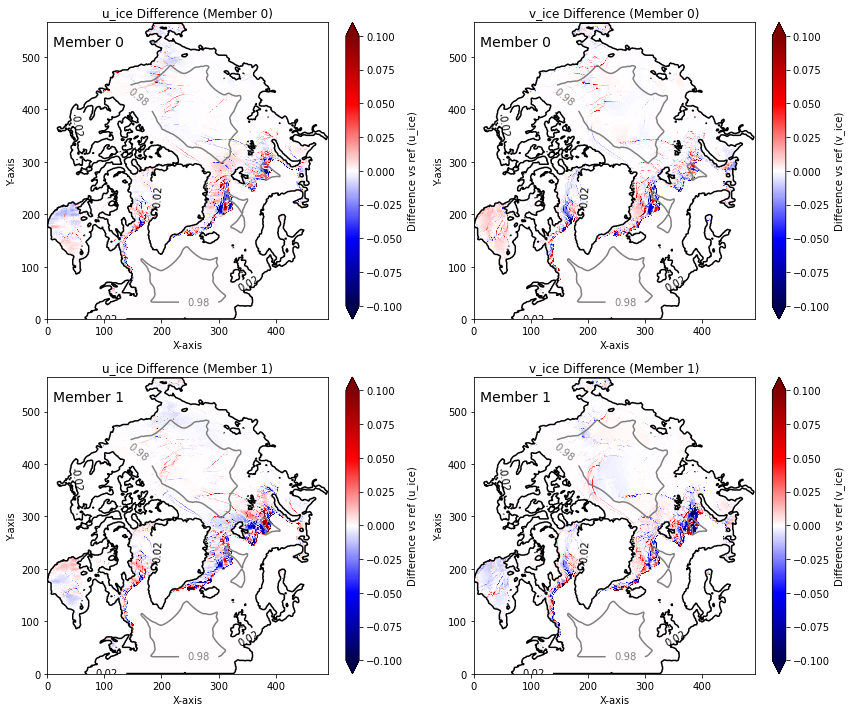

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/diff_4panels_ls500km_lgrid10_std10_D0.png


In [35]:

# Define reference data and separate masks for u_ice and v_ice
ref_u_ice = ref["u_ice"].squeeze()
ref_v_ice = ref["v_ice"].squeeze()
mask_u_ice = mask["u_ice"].squeeze()  # Mask for u_ice field
mask_v_ice = mask["v_ice"].squeeze()  # Mask for v_ice field

# Compute the difference for each member and apply the respective mask
members = [0, 1]  # Member indices

# Compute the differences for u_ice and apply the mask
diffs_u_ice = [
    pertfields["u_ice"].squeeze().isel(member=member) - ref_u_ice
    for member in members
]
masked_diffs_u_ice = [diff.where(mask_u_ice > 0) for diff in diffs_u_ice]

# Compute the differences for v_ice and apply the mask
diffs_v_ice = [
    pertfields["v_ice"].squeeze().isel(member=member) - ref_v_ice
    for member in members
]
masked_diffs_v_ice = [diff.where(mask_v_ice > 0) for diff in diffs_v_ice]

# Compute the grid scaling factor
grid_factor = np.sqrt(0.5 * (grid["e1t"][0, :, :]**2 + grid["e2t"][0, :, :]**2))
grid_factor = grid_factor / 1000.0  # Convert to km

# Scale the damping coefficient
scaled_damping = damping["a_i"] * grid_factor

# Define contour levels and colors for scaled damping
contour_levels = [0.02, 0.98]
contour_colors = ['black', 'gray']

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=[12, 10], facecolor='w')

# Set common vmin and vmax for the color scale (difference ranges)
vmin, vmax = -0.1, 0.1
cmap = "seismic"

# Loop over members and plot the differences for u_ice and v_ice
for i, member in enumerate(members):
    # Plot difference for u_ice (dx panel)
    ax = axes[i, 0]
    p = ax.pcolormesh(masked_diffs_u_ice[i], vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(f"u_ice Difference (Member {member})")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    fig.colorbar(p, ax=ax, label='Difference vs ref (u_ice)', extend='both')
    # Add member annotation
    ax.text(10, 520, f"Member {member}", fontsize=14, color="k", backgroundcolor='white')

    # Add contours for scaled damping
    contour = ax.contour(
        scaled_damping[0, 0, :, :],
        levels=contour_levels,
        colors=contour_colors,
        linewidths=1.5
    )
    ax.clabel(contour, inline=True, fontsize=10, fmt='%1.2f')

    # Plot difference for v_ice (dy panel)
    ax = axes[i, 1]
    p = ax.pcolormesh(masked_diffs_v_ice[i], vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(f"v_ice Difference (Member {member})")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    fig.colorbar(p, ax=ax, label='Difference vs ref (v_ice)', extend='both')
    # Add member annotation
    ax.text(10, 520, f"Member {member}", fontsize=14, color="k", backgroundcolor='white')

    # Add contours for scaled damping
    contour = ax.contour(
        scaled_damping[0, 0, :, :],
        levels=contour_levels,
        colors=contour_colors,
        linewidths=1.5
    )
    ax.clabel(contour, inline=True, fontsize=10, fmt='%1.2f')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Save the figure
Fsaveplt(fig, LUdir, "diff_4panels_ls"+str(ls)+"km_lgrid"+str(lgrid)+"_std"+str(std)+"_"+label)


* zoom over central region

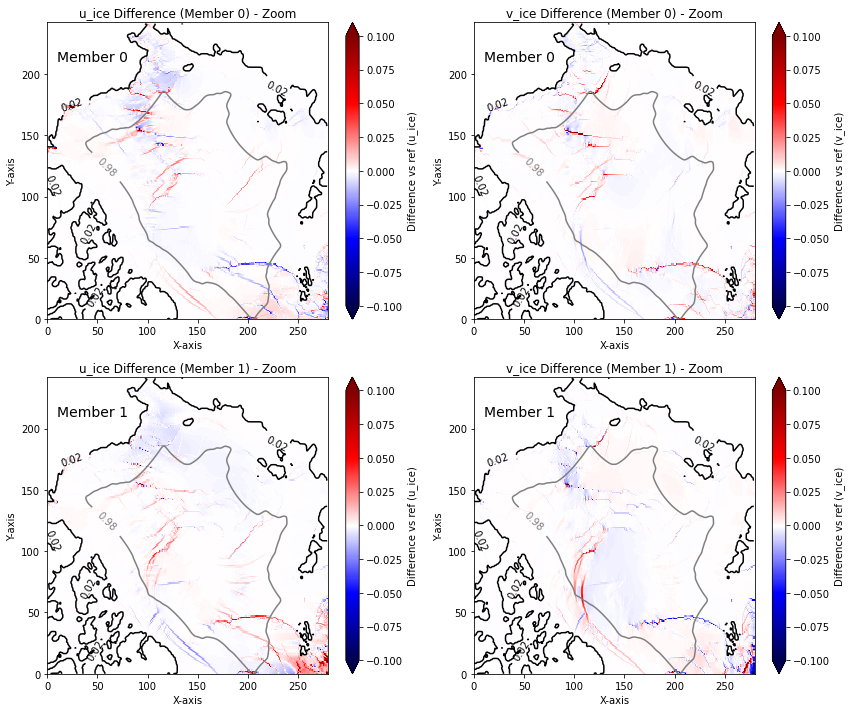

/lustre/fswork/projects/rech/cli/regi915/DEVGIT/ArcticBLISS-all/lu-simulator/examples/zoom_diff_4panels_ls500km_lgrid10_std10_D0.png


In [36]:
# Define the zoom indices
zoom_indices = (slice(298, 540), slice(100, 380))
vmin=-0.1
vmax=0.1
# Define reference data and separate masks for u_ice and v_ice
ref_u_ice = ref["u_ice"].squeeze()
ref_v_ice = ref["v_ice"].squeeze()
mask_u_ice = mask["u_ice"].squeeze()  # Mask for u_ice field
mask_v_ice = mask["v_ice"].squeeze()  # Mask for v_ice field

# Compute the difference for each member and apply the respective mask
members = [0, 1]  # Member indices

# Compute the differences for u_ice and apply the mask
diffs_u_ice = [
    pertfields["u_ice"].squeeze().isel(member=member) - ref_u_ice
    for member in members
]
masked_diffs_u_ice = [diff.where(mask_u_ice > 0) for diff in diffs_u_ice]

# Compute the differences for v_ice and apply the mask
diffs_v_ice = [
    pertfields["v_ice"].squeeze().isel(member=member) - ref_v_ice
    for member in members
]
masked_diffs_v_ice = [diff.where(mask_v_ice > 0) for diff in diffs_v_ice]

# Compute the grid scaling factor
grid_factor = np.sqrt(0.5 * (grid["e1t"][0, :, :]**2 + grid["e2t"][0, :, :]**2))
grid_factor = grid_factor / 1000.0  # Convert to km

# Scale the damping coefficient
scaled_damping = damping["a_i"] * grid_factor

# Define contour levels and colors for scaled damping
contour_levels = [0.02, 0.98]
contour_colors = ['black', 'gray']

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=[12, 10], facecolor='w')

# Loop over members and plot the zoomed differences for u_ice and v_ice
for i, member in enumerate(members):
    # Plot difference for u_ice (dx panel)
    ax = axes[i, 0]
    zoomed_diff_u_ice = masked_diffs_u_ice[i].isel(x=zoom_indices[1], y=zoom_indices[0])
    p = ax.pcolormesh(
        zoomed_diff_u_ice,
        vmin=vmin, vmax=vmax, cmap=cmap
    )
    ax.set_title(f"u_ice Difference (Member {member}) - Zoom")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    fig.colorbar(p, ax=ax, label='Difference vs ref (u_ice)', extend='both')
    # Add member annotation
    ax.text(10, 210, f"Member {member}", fontsize=14, color="k", backgroundcolor='white')

    # Add contours for scaled damping
    zoomed_damping = scaled_damping[0, 0, zoom_indices[0], zoom_indices[1]]
    contour = ax.contour(
        zoomed_damping,
        levels=contour_levels,
        colors=contour_colors,
        linewidths=1.5
    )
    ax.clabel(contour, inline=True, fontsize=10, fmt='%1.2f')

    # Plot difference for v_ice (dy panel)
    ax = axes[i, 1]
    zoomed_diff_v_ice = masked_diffs_v_ice[i].isel(x=zoom_indices[1], y=zoom_indices[0])
    p = ax.pcolormesh(
        zoomed_diff_v_ice,
        vmin=vmin, vmax=vmax, cmap=cmap
    )
    ax.set_title(f"v_ice Difference (Member {member}) - Zoom")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    fig.colorbar(p, ax=ax, label='Difference vs ref (v_ice)', extend='both')
    # Add member annotation
    ax.text(10, 210, f"Member {member}", fontsize=14, color="k", backgroundcolor='white')

    # Add contours for scaled damping
    contour = ax.contour(
        zoomed_damping,
        levels=contour_levels,
        colors=contour_colors,
        linewidths=1.5
    )
    ax.clabel(contour, inline=True, fontsize=10, fmt='%1.2f')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Save the figure
Fsaveplt(fig, LUdir, "zoom_diff_4panels_ls"+str(ls)+"km_lgrid"+str(lgrid)+"_std"+str(std)+"_"+label)
